In [1]:
import pandas as pd
from pandas import MultiIndex, Int64Index
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, plot_roc_curve
import warnings
from xgboost import XGBClassifier, cv
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")

/var/folders/zf/b9vg7zkj089d71t0qkrb1zmm0000gn/T/ipykernel_12154/1057915438.py:2: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. Tree-Based Methods

## (a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/ APS+Failure+at+Scania+Trucks . The dataset contains a training set and a testset. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are nu- meric.

In [2]:
train_df = pd.read_csv("../data/aps_failure_training_set.csv", skiprows=20, na_values='na')
test_df = pd.read_csv("../data/aps_failure_test_set.csv", skiprows=20, na_values='na')

In [3]:
print("Training Set Shape", train_df.shape)
print("Test Set Shape", test_df.shape)

Training Set Shape (60000, 171)
Test Set Shape (16000, 171)


## (b) Data Preparation This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea. 1

In [4]:
train_df.replace('na', np.nan, inplace = True)
test_df.replace('na', np.nan, inplace = True)

df = pd.concat([train_df, test_df])
df.shape

(76000, 171)

### i. Research what types of techniques are usually used for dealing with data with missing values.2 Pick at least one of them and apply it to this data in the next steps.3

In [5]:
print("Dataset Contains Missing Values: ", df.isna().any().any())

Dataset Contains Missing Values:  True


In [6]:
X, y = df.iloc[:,1:], df.iloc[:,:1]
print(X.shape)
print(y.shape)

(76000, 170)
(76000, 1)


In [7]:
for col in X.columns:
    X[col].fillna((X[col].median()), inplace = True)

median_cache = {}
for col in train_df.columns[1:]:
    median_cache[col] = train_df[col].median()
    train_df[col].fillna((median_cache[col]), inplace = True)

for col in test_df.columns[1:]:
    test_df[col].fillna((median_cache[col]), inplace = True)

In [8]:
print("Dataset Contains Missing Values: ", X.isna().any().any())

Dataset Contains Missing Values:  False


### ii. For each of the 170 features, calculate the coefficient of variation CV = ms , where s is sample standard deviation and m is sample mean.

In [9]:
COL_CV = []
for col in X.columns:
    COL_CV.append((col, (X[col].std()/X[col].mean())))
cv_df = pd.DataFrame(COL_CV, columns=['Feature', 'Coefficient of Variation'])
cv_df

,Feature,Coefficient of Variation
0,aa_000,4.328608
1,ab_000,9.740521
2,ac_000,2.309299
3,ad_000,274.790378
4,ae_000,23.271357
...,...,...
165,ee_007,4.935380
166,ee_008,3.373881
167,ee_009,5.821008
168,ef_000,50.223681


### iii. Plot a correlation matrix for your features using pandas or any other tool.

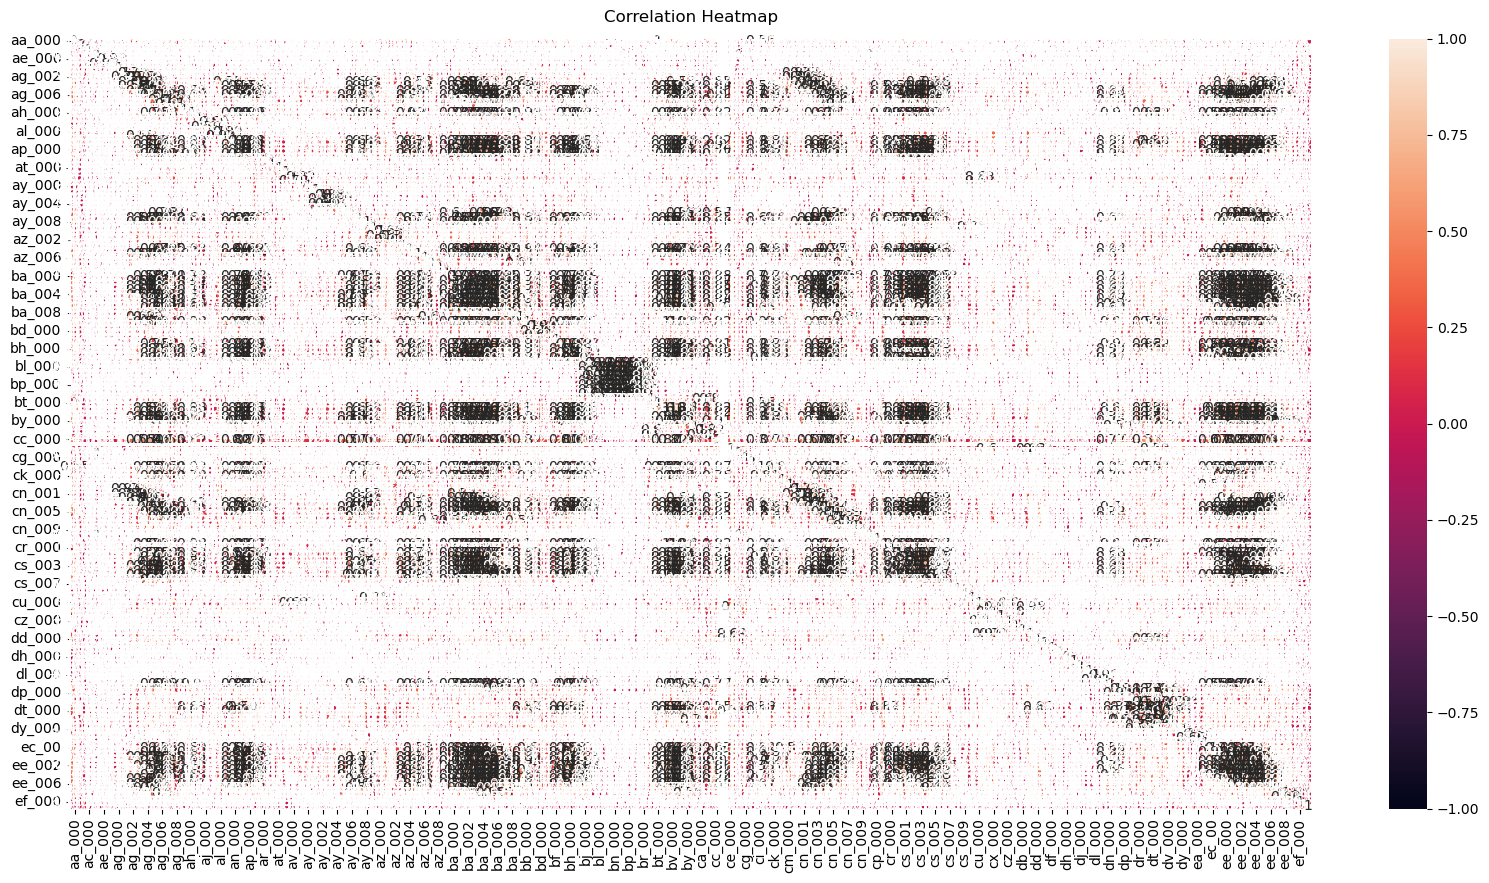

In [10]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [11]:
X.corr()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.009953,-0.037851,-0.000801,0.023778,0.033524,0.011686,0.076387,0.195179,0.307466,...,0.414098,0.419884,0.409628,0.419753,0.425622,0.356954,0.259626,0.133790,0.005648,0.009239
ab_000,0.009953,1.000000,-0.002489,-0.000372,0.034129,0.053156,-0.000206,0.006841,0.024010,0.037640,...,-0.000332,0.010885,0.001855,0.012073,0.016158,0.010747,-0.026319,-0.017057,0.051733,0.077262
ac_000,-0.037851,-0.002489,1.000000,-0.001568,-0.004005,-0.009773,0.015077,-0.007137,-0.022578,-0.046973,...,-0.047540,-0.041136,-0.040610,-0.041436,-0.047661,-0.048884,-0.004806,0.012019,-0.006200,0.016273
ad_000,-0.000801,-0.000372,-0.001568,1.000000,-0.000156,-0.000190,-0.000038,-0.000085,-0.000202,-0.000407,...,-0.001343,-0.001350,-0.001318,-0.001092,-0.001054,-0.000722,-0.001060,-0.000622,-0.000072,-0.000076
ae_000,0.023778,0.034129,-0.004005,-0.000156,1.000000,0.830001,-0.000465,-0.000953,0.000977,0.018881,...,0.009860,0.016805,0.010357,0.023873,0.063898,0.034168,-0.009518,-0.007330,0.063622,0.030893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.356954,0.010747,-0.048884,-0.000722,0.034168,0.043477,0.007652,0.067999,0.181955,0.475604,...,0.442405,0.433122,0.419859,0.380362,0.543650,1.000000,0.227539,0.063395,-0.001551,-0.000363
ee_008,0.259626,-0.026319,-0.004806,-0.001060,-0.009518,-0.012225,0.000102,0.005364,0.009142,0.020924,...,0.442837,0.470860,0.448713,0.394357,0.366141,0.227539,1.000000,0.690270,-0.005663,-0.002474
ee_009,0.133790,-0.017057,0.012019,-0.000622,-0.007330,-0.009004,-0.001082,-0.003530,-0.009065,-0.018009,...,0.224864,0.236117,0.221077,0.184135,0.158955,0.063395,0.690270,1.000000,-0.003312,-0.001216
ef_000,0.005648,0.051733,-0.006200,-0.000072,0.063622,0.093517,-0.000086,0.000960,0.005119,0.010094,...,0.002271,0.008862,0.001752,0.025645,0.003997,-0.001551,-0.005663,-0.003312,1.000000,0.222595


### iv. Pick ⌊ 170⌋ features with highest CV , and make scatter plots and box plotsfor them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [12]:
num_features = math.floor(math.sqrt(170))
print("Number of features needed: ", num_features)

Number of features needed:  13


In [13]:
COL_CV.sort(key = lambda x: x[1], reverse = True)
temp_df = pd.DataFrame(COL_CV[:num_features],columns=['Feature', 'CV'])
temp_df

,Feature,CV
0,cf_000,275.595820
1,co_000,275.068138
2,ad_000,274.790378
3,cs_009,194.720937
4,dj_000,130.915233
5,dh_000,120.759504
6,df_000,119.384411
7,as_000,115.082077
8,ag_000,92.507510
9,au_000,86.992248


In [14]:
required_cols = temp_df['Feature'].values.tolist()
viz_df = X[required_cols].copy()
viz_df = viz_df.reset_index(drop=True)
viz_df.head(10)

,cf_000,co_000,ad_000,cs_009,dj_000,dh_000,df_000,as_000,ag_000,au_000,ak_000,az_009,ay_009
0,2.0,220.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,8.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,2.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,202.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,2.0,218.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.0,8.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,6.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2.0,8.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
9,2.0,8.0,128.0,0.0,0.0,55760.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
y = y.reset_index(drop=True)
viz_df = pd.concat([viz_df, y], axis=1)

In [16]:
viz_df.columns

Index(['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'dh_000', 'df_000',
       'as_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009', 'class'],
      dtype='object')

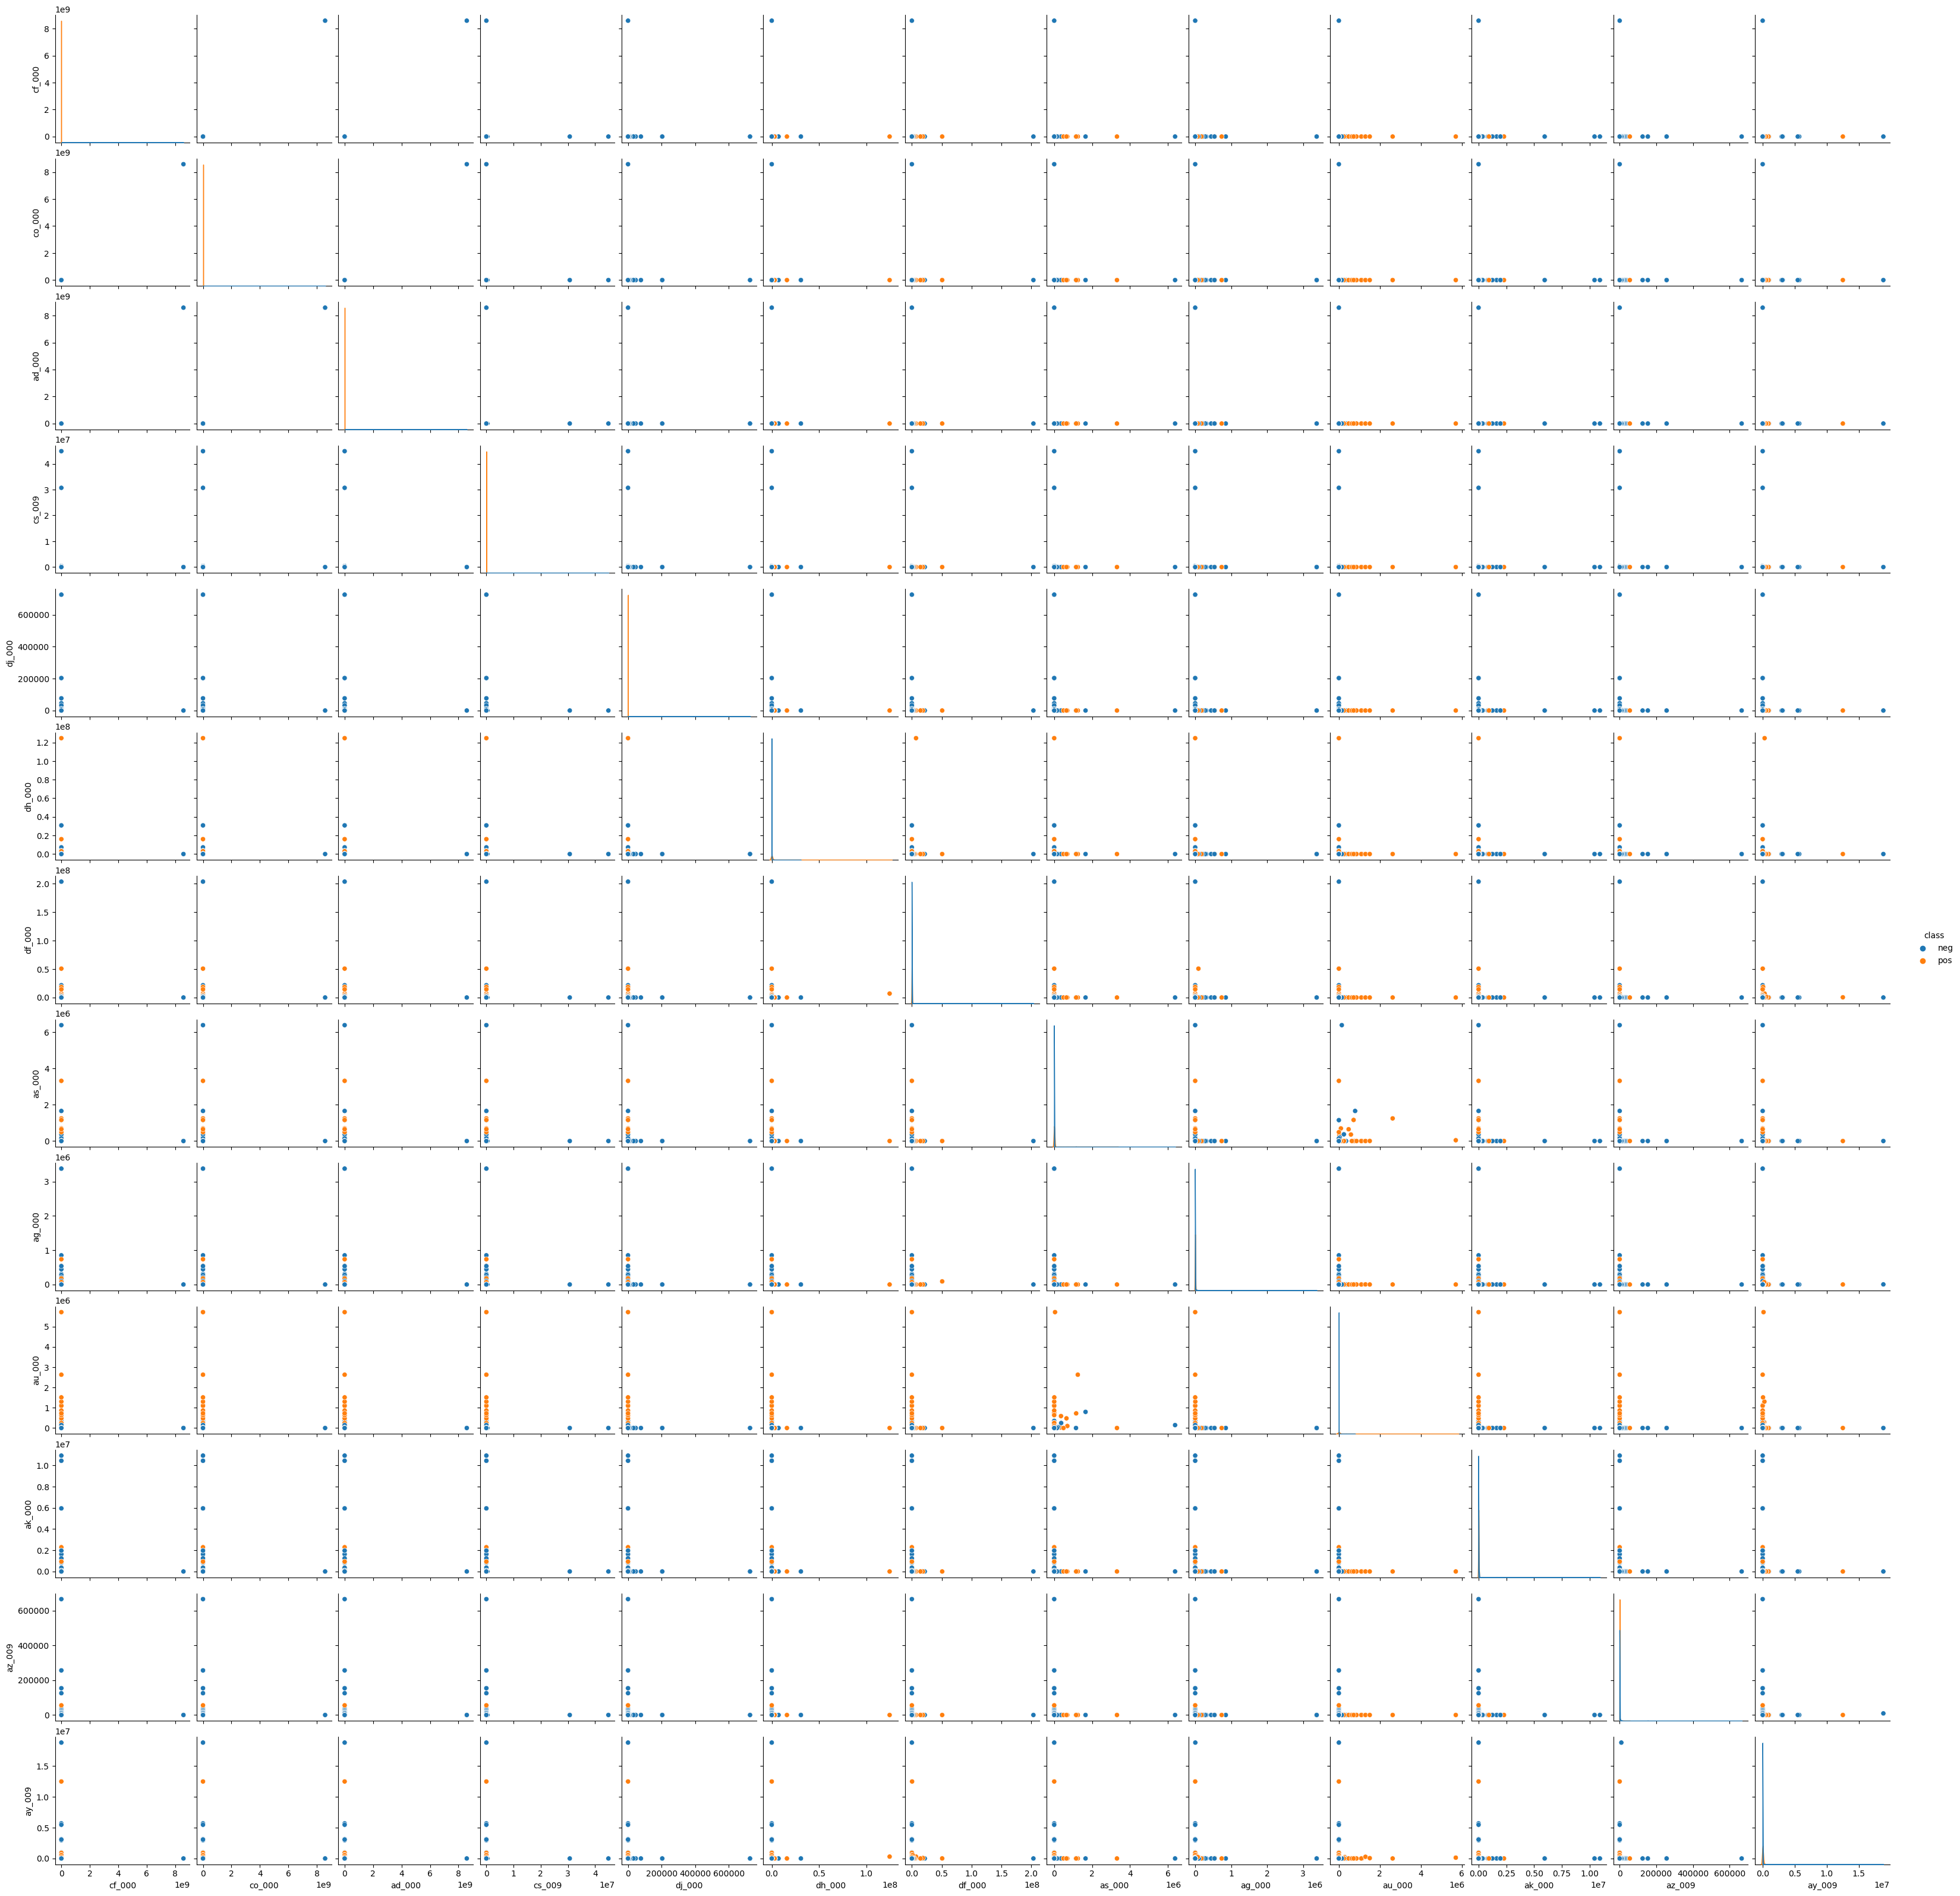

In [17]:
sns.pairplot(viz_df,hue='class', diag_kind='kde')

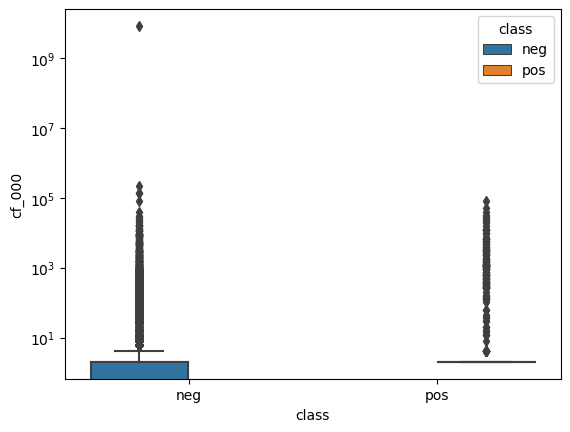

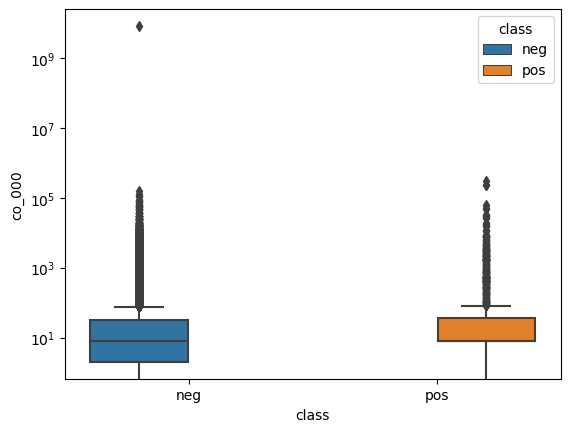

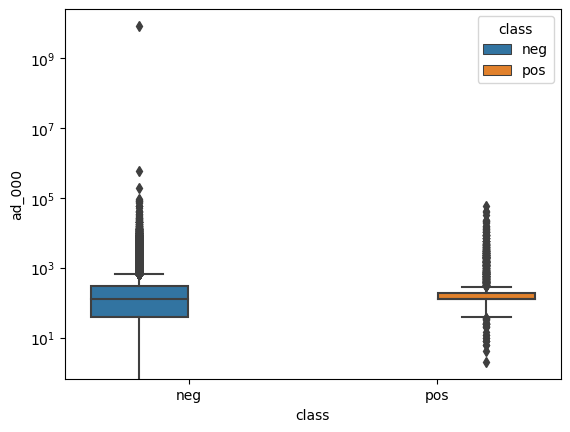

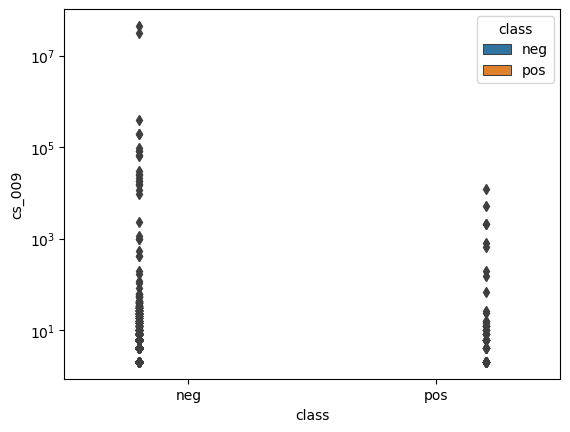

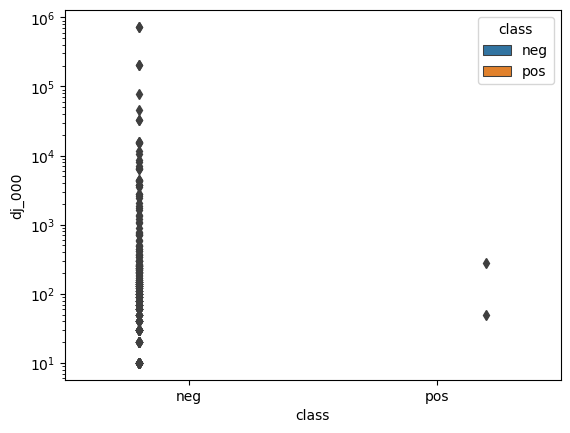

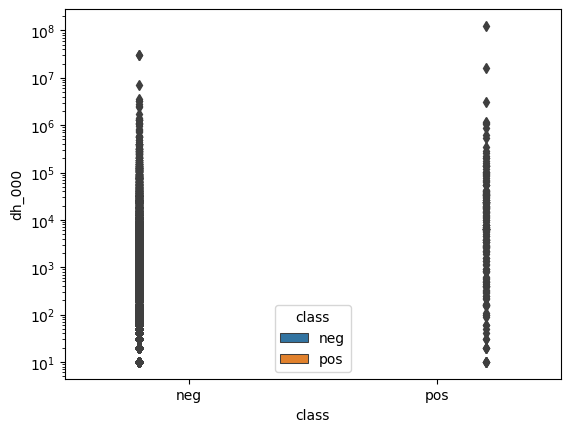

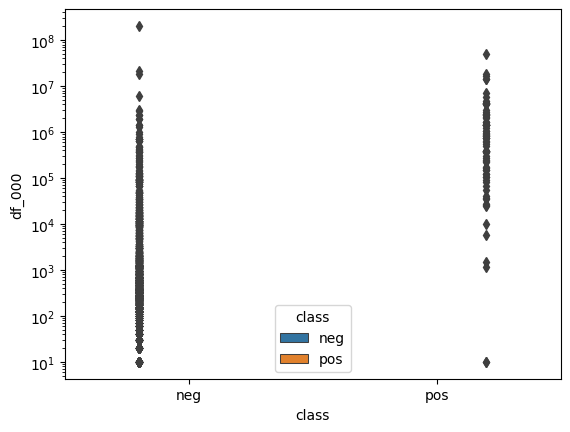

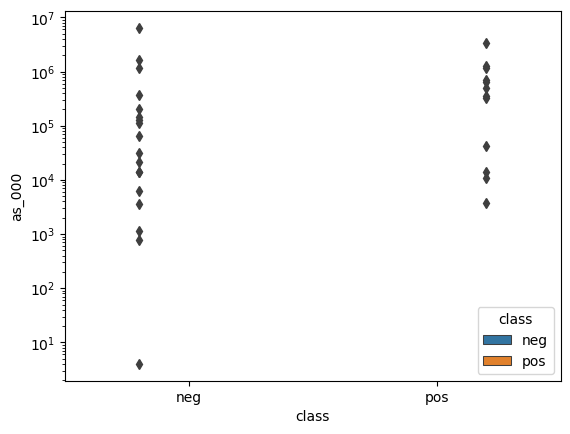

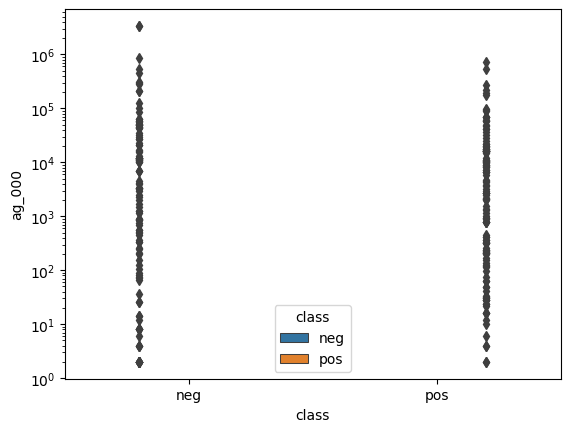

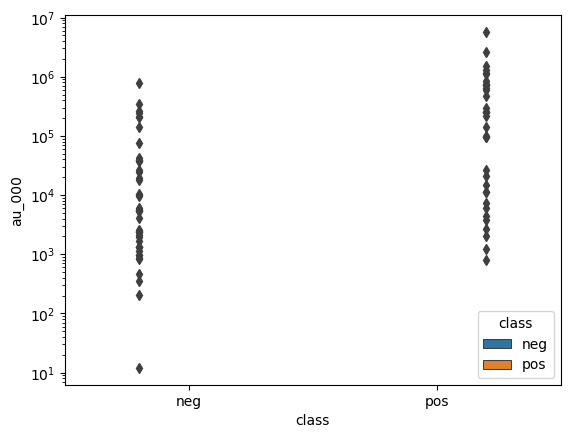

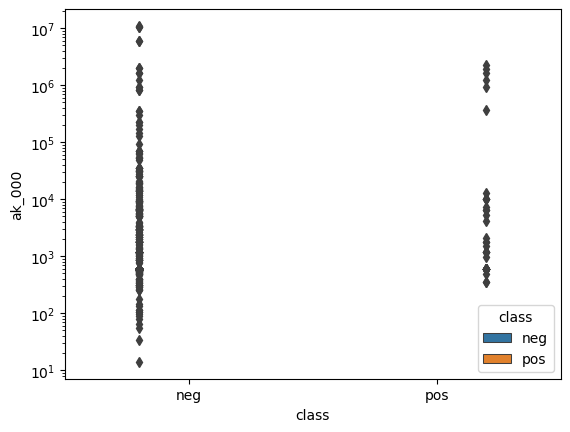

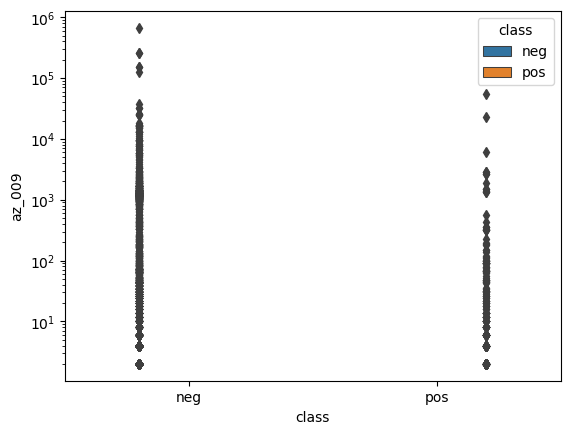

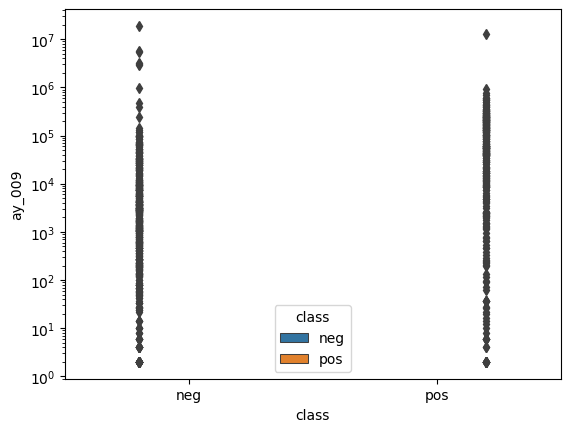

In [18]:
for col in viz_df.columns[:-1]:
    t = sns.boxplot(x=viz_df['class'],y=viz_df[col],hue=viz_df['class'])
    t.set_yscale("log")
    plt.show()

### v. Determine the number of positive and negative data. Is this data set imbal- anced?

In [19]:
print("Entire Dataset [Train + Test]")
y.value_counts()

Entire Dataset [Train + Test]


class
neg      74625
pos       1375
dtype: int64

In [20]:
print("Training Set")
train_df['class'].value_counts()

Training Set


neg    59000
pos     1000
Name: class, dtype: int64

In [21]:
print("Test Set")
test_df['class'].value_counts()

Test Set


neg    15625
pos      375
Name: class, dtype: int64

## (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [22]:
X_train, y_train = train_df.iloc[:,1:], train_df.iloc[:,0]
X_test, y_test = test_df.iloc[:,1:], test_df.iloc[:,0]

In [23]:
LE = LabelEncoder()
LE.fit(y_train)
print(LE.classes_)
y_train = LE.transform(y_train)
y_test = LE.transform(y_test)

['neg' 'pos']


Training Score is 1.0
Training Confusion Matrix
[[59000     0]
 [    0  1000]]
Training ROC Curve


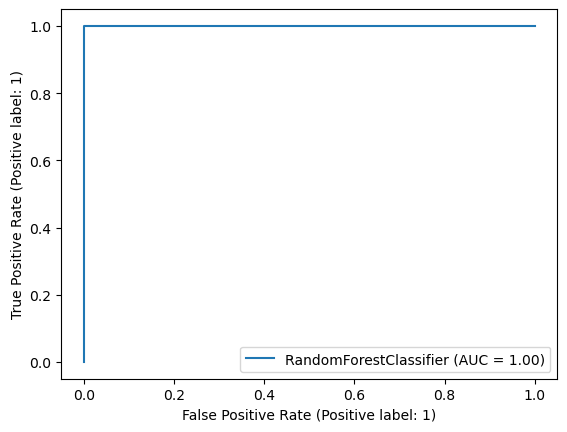

Training Misclassification  0.0
Test Score is 0.9924375
Test Confusion Matrix
[[15607    18]
 [  103   272]]
Test ROC Curve


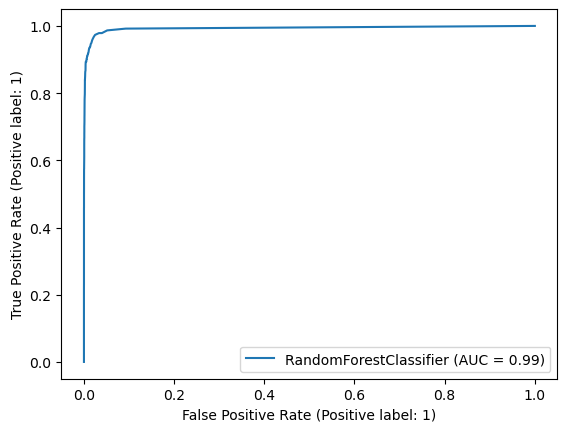

Test Misclassification  0.0075625000000000275


In [24]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
yhat = rf.predict(X_train)
score = rf.score(X_train, y_train)
print("Training Score is" , score)
print("Training Confusion Matrix")
print(confusion_matrix(y_train, yhat))
print("Training ROC Curve")
plot_roc_curve(rf, X_train, y_train)
plt.show()
print("Training Misclassification ", (1-score))

yhat = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Test Score is" , score)
print("Test Confusion Matrix")
print(confusion_matrix(y_test, yhat))
print("Test ROC Curve")
plot_roc_curve(rf, X_test, y_test)
plt.show()
print("Test Misclassification ", (1-score))

In [25]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score = True)
rf.fit(X_train, y_train)
yhat = rf.predict(X_train)
score = rf.score(X_train, y_train)
print("OOB Score is" , rf.oob_score_)

yhat = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Test Score is" , score)

OOB Score is 0.9939666666666667
Test Score is 0.99225


## (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

Training Score is 1.0
Training Confusion Matrix
[[59000     0]
 [    0  1000]]
Training ROC Curve


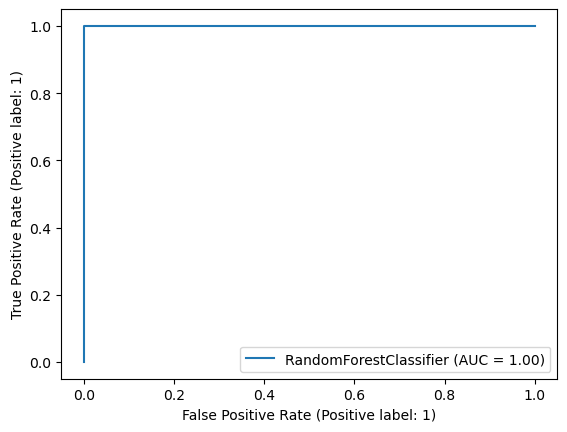

Training Misclassification  0.0
Test Score is 0.9886875
Test Confusion Matrix
[[15608    17]
 [  164   211]]
Test ROC Curve


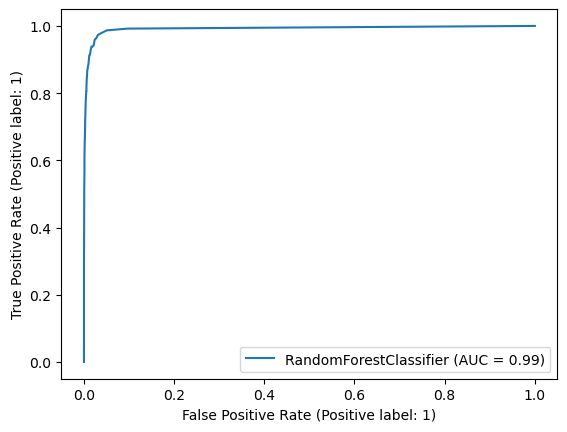

Test Misclassification  0.011312499999999948


In [26]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)
yhat = rf.predict(X_train)
score = rf.score(X_train, y_train)
print("Training Score is" , score)
print("Training Confusion Matrix")
print(confusion_matrix(y_train, yhat))
print("Training ROC Curve")
plot_roc_curve(rf, X_train, y_train)
plt.show()
print("Training Misclassification ", (1-score))

yhat = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Test Score is" , score)
print("Test Confusion Matrix")
print(confusion_matrix(y_test, yhat))
print("Test ROC Curve")
plot_roc_curve(rf, X_test, y_test)
plt.show()
print("Test Misclassification ", (1-score))

In [27]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score = True, class_weight='balanced')
rf.fit(X_train, y_train)
yhat = rf.predict(X_train)
score = rf.score(X_train, y_train)
print("OOB Score is" , rf.oob_score_)

yhat = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Test Score is" , score)

OOB Score is 0.9922833333333333
Test Score is 0.989


In [28]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

## e) XGBoost and Model Trees
## In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has 􏰀j βjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node. One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [29]:
xgb_model = XGBClassifier(objective = 'binary:logistic', eval_metric='error',use_label_encoder=False)
params = {'alpha': np.linspace(0.0001, 0.1, 20)}
model = RandomizedSearchCV(estimator = xgb_model,param_distributions = params, n_jobs=-1, cv=5, scoring='accuracy')
model.fit(X_train,y_train)

/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecate

/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost

/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/serotonin/opt/anaconda3/envs/dsml/lib/python3.9/site-packages/xgboost

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='error', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,...
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False,
                                           validate_parameters=None,
                                           verbosity=None),
                   n_jobs=-1,
                   param_distributions={'alpha': array([0.0001    , 0.00535789, 0.01061579, 0.01587368, 0.02113158,
       0.02638947, 0.03164737, 0.03690526, 0.04216316, 0.04742105,
       0.05267895, 0.05793684, 0.06319474, 0.06845263, 0.07371053,
       0.07896842, 0.08422632, 0.08948421, 0.09474211, 0.1       ])},
                   scoring='accuracy')

In [30]:
print("Best Params", model.best_params_)
best_model = model.best_estimator_

Best Params {'alpha': 0.08948421052631579}


Training Error Score is 1.666666666666483e-05
Training Confusion Matrix
[[59000     0]
 [    1   999]]
Training ROC Curve


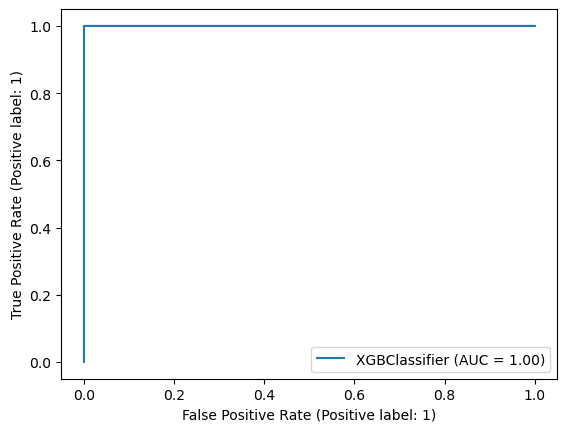

Test Error Score is 0.006249999999999978
Test Confusion Matrix


NameError: name 'y_test_le' is not defined

In [31]:
yhat = best_model.predict(X_train)
score = best_model.score(X_train, y_train)
print("Training Error Score is" , 1-score)
print("Training Confusion Matrix")
print(confusion_matrix(y_train, yhat))
print("Training ROC Curve")
plot_roc_curve(best_model, X_train, y_train)
plt.show()

yhat = best_model.predict(X_test)
score = best_model.score(X_test, y_test)
print("Test Error Score is" , 1-score)
print("Test Confusion Matrix")
print(confusion_matrix(y_test_le, yhat))
print("Test ROC Curve")
plot_roc_curve(best_model, X_test, y_test_le)
plt.show()

## (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.4 Train XGBosst with L1-penalized lo- gistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [ ]:
xgb_model = XGBClassifier(objective = 'binary:logistic', eval_metric='error',use_label_encoder=False)
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=23)],
                                ['classifier', xgb_model]])
params = {'classifier__reg_alpha': np.linspace(0.0001, 0.1,20)}
model = RandomizedSearchCV(estimator = pipeline,param_distributions = params,n_jobs=-1, cv=5, scoring='accuracy')
model.fit(X_train,y_train)

In [ ]:
print("Best Params", model.best_params_)
best_model = model.best_estimator_

In [ ]:
yhat = best_model.predict(X_train)
score = best_model.score(X_train, y_train)
print("Training Score is" , score)
print("Training Confusion Matrix")
print(confusion_matrix(y_train, yhat))
print("Training ROC Curve")
plot_roc_curve(best_model, X_train, y_train)
plt.show()

yhat = best_model.predict(X_test)
LE = LabelEncoder()
y_test_le = LE.fit_transform(y_test)
score = best_model.score(X_test, y_test_le)
print("Test Score is" , score)
print("Test Confusion Matrix")
print(confusion_matrix(y_test_le, yhat))
print("Test ROC Curve")
plot_roc_curve(best_model, X_test, y_test_le)
plt.show()

# 2. ISLR 6.6.3

# 3. ISLR, 6.6.5

# 4. ISLR 8.4.5

# 5. ISLR 9.7.3